## KEYWORD IDENTIFICATION

In [127]:
import requests 
from bs4 import BeautifulSoup
import re
from collections import Counter
import sqlite3
from typing import Dict, Iterable, Tuple, List
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import yake

### We will first do scarping, cleaning and counting for the site.

In [128]:
def scrape_clean_count(url: str):

    #-------------------------------------------------------------------------------------------------------------------------------#
    #-------------------------------------------------------GETTING URL-------------------------------------------------------------#  
    #-------------------------------------------------------------------------------------------------------------------------------#  
    
    response = requests.get(url)
    # Check if request succeeded
    if response.status_code == 200: # This typically means done succesfully.
        html_content = response.text  # This is the raw HTML.
        print("Successfully fetched the webpage!:", url)
        print("")
    else:
        print("Failed to fetch the webpage. Status code:", response.status_code)
    # with the webpage taken in successfully, we have entire html script that can be checked by uncommeting below line.
    # print(html_content)



    #-------------------------------------------------------------------------------------------------------------------------------#
    #-------------------------------------------------GETTING, THINGS INSIDE VALID HTML TAGS----------------------------------------#  
    #-------------------------------------------------------------------------------------------------------------------------------#  

    # now we need to extract the text out from this html.
    # Parse the HTML content
    soup = BeautifulSoup(html_content, 'html.parser')
    # html
    # ├── head
    # │   └── title → 'IISER Mohali'
    # └── body
    #     ├── h1 → 'Welcome to IISER Mohali'
    #     ├── p  → 'Indian Institute...'
    #     └── p  → 'Established by...'
    # We are assuming that all text content is within these tags.
    # This is a very basic assumption and may not work for all websites.
    # Best way to check is to inspect the website and see where the text lies.
    # Extract text from common tags
    valid_tags = ['p', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'li'] # valid tags only from the html file, h->heading, p->paragraph, li->list
    text = " ".join([element.get_text() for element in soup.find_all(valid_tags)]) # join the entire string into one.
    # print(text) # uncomment this to check the text at this moment, you see everything in the associated tags. 



    #-------------------------------------------------------------------------------------------------------------------------------#
    #-------------------------------------CLEANING THE TEXT TO GET LOGICAL WORDS (TO SOME EXTENT)-----------------------------------#  
    #-------------------------------------------------------------------------------------------------------------------------------#  

    # As noted the text is not clean, it contains numbers, symbol, characters and everything, that may or my not be of physical significance.
    # but we logial words, and therefore we do the following:
    Clean_text = text.lower() #convert text to lower case.
    Clean_text =re.sub(r'[^a-z\s]', ' ',Clean_text) # remove all except alphabets and replace with space.
    Clean_text = re.sub(r'\b(?![ai]\b)[a-z]\b',' ',Clean_text) # remove all single letters except a and i, replace with space.
    Clean_text = re.sub(r'\s+',' ',Clean_text).strip() # remove multiple spaces to replace with single space.
    #print(Clean_text) # uncomment here to verify thism, we have the clean string of words from the site seperated by the space.



    #-------------------------------------------------------------------------------------------------------------------------------#
    #-------------------------------------------COUNTING AND GETTING THE FREQUENCY--------------------------------------------------#  
    #-------------------------------------------------------------------------------------------------------------------------------# 
    
    # Now we need to go through the string and get the unique words, and frequency (i.e. number of times the word appeared).
    Words = Clean_text.split() # splits the cleaned string over white spaces.
    Word_counter = Counter(Words) # gets frequency of words alongwith words to check uncomment below.
    #print (Word_counter) 
    # for observation properly uncomment below 
    #most_used = Word_counter.most_common() # top 20 or as needed by frequency.
    #for word,freq in most_used:
    #    print(f"{word:>12} : {freq}")
    #
    # Now we have words alongwith their frequency store in the Word_counter, which is the dictionary
    
    return Word_counter # for further analysis


#-------------------------------------------------------------------------------------------------------------------------------#
#---------------------------------------------Gives only clean text for the url-------------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------#  

def clean_text(url: str):
    response = requests.get(url)
    if response.status_code == 200: 
        html_content = response.text  
        print("Successfully fetched the webpage!:", url)
        print("")
    else:
        print("Failed to fetch the webpage. Status code:", response.status_code)
    soup = BeautifulSoup(html_content, 'html.parser')
    valid_tags = ['p', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'li'] 
    text = " ".join([element.get_text() for element in soup.find_all(valid_tags)]) 
    Clean_text = text.lower() 
    Clean_text =re.sub(r'[^a-z\s]', ' ',Clean_text)
    Clean_text = re.sub(r'\b(?![ai]\b)[a-z]\b',' ',Clean_text) 
    Clean_text = re.sub(r'\s+',' ',Clean_text).strip() 
    return Clean_text



# to see how the function's output looks like
# scrape_clean_count("https://www.iisermohali.ac.in/")

### With word counting done, next we store data in SQLite3.

In [129]:
# SQLite is a self-contained database that stores data in a single file (like data.db).
# You don’t need to run a separate database server, it is built into Python and perfect for “store plus query later” tasks.
# In your case, you want to store:
# each URL,
# each word from that URL, and
# the frequency of that word.

# Database	A single file that holds tables (e.g., keywords.db)
# Table	    A sheet-like structure (e.g., one table for word counts)
# Row	    A single record (e.g., one word’s count for one URL)
# Column	A field in each row (e.g., URL, word, frequency)
# Cursor	A helper that executes SQL commands and returns results
# SQL	    The language we use to create, insert, and read data

#-------------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------Create or Connect to DataBase-------------------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------# 

def initiate_db(db_path: str = "keywords.db"):
    # Make the data base. Or get connected to the database.
    conn = sqlite3.connect(db_path)

    # To work in it we have cursor. (" way of talking to the database ")
    cur = conn.cursor()

    # Next up tell data base what to do
    # CREATE TABLE  → make a new table.
    # IF NOT EXISTS → don’t complain if it’s already there.
    # The parentheses define columns:
    # id       : unique number auto-generated for each row.
    # url      : text (string).
    # word     : text.
    # frequency: integer.
    # UNIQUE   : prevents repetition.
    cur.execute("""
    CREATE TABLE IF NOT EXISTS word_counts (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        url TEXT NOT NULL,
        word TEXT NOT NULL,
        frequency INTEGER NOT NULL, 
        UNIQUE(url, word) 
    )
    """)

    # Build an internal quick-lookup structure (called idx_url) so queries filtering by the url column are faster.
    conn.execute("CREATE INDEX IF NOT EXISTS idx_url ON word_counts(url)")
    # It speeds up queries like “find where word = 'research'.”
    conn.execute("CREATE INDEX IF NOT EXISTS idx_word ON word_counts(word)")

    # Save the changes you have made.
    conn.commit()   
    return conn



#-------------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------Write and Save in the Database------------------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------# 

def save_counter_overwrite(conn: sqlite3.Connection, url: str, word_counter: Counter):
    """
    Save all (word, freq) pairs for `url`. If a row for (url,word) already exists,
    overwrite its frequency with the new value (your chosen behavior).
    Uses executemany for speed and runs inside a single transaction.
    """
    # first  ? → url,
    # second ? → word,
    # third  ? → freq.
    # So the code is really saying:
    # Insert a new row into the word_counts table, filling the columns with these values in order.
    # If pair (url, word) is repeated we replace it the latest one.
    sql = """
    INSERT INTO word_counts (url, word, frequency)
    VALUES (?, ?, ?)
    ON CONFLICT(url, word) DO UPDATE
      SET frequency = excluded.frequency
    """
    # If you have many (url, word, freq) rows (like your whole Counter), calling execute() one-by-one is slow.
    # executemany().
    # Make a list.
    data = [(url, word, int(freq)) for word, freq in word_counter.items()]
    cur = conn.cursor()
    cur.executemany(sql, data)
    conn.commit()


def save_yake_keywords(conn, url: str, yake_results):

    # Store YAKE keywords and scores for each URL.
    cur = conn.cursor()
    cur.execute("""
    CREATE TABLE IF NOT EXISTS yake_keywords (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        url TEXT NOT NULL,
        keyword TEXT NOT NULL,
        score REAL NOT NULL,
        UNIQUE(url, keyword)
    )
    """)
    sql = """
    INSERT INTO yake_keywords (url, keyword, score)
    VALUES (?, ?, ?)
    ON CONFLICT(url, keyword) DO UPDATE SET score = excluded.score
    """
    data = [(url, kw, float(score)) for kw, score in yake_results]
    cur.executemany(sql, data)
    conn.commit()



#-------------------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------HELPER FUNCTIONS SINGLE URL----------------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------#

#-------------------------------------------------------------------------------------------------------------------------------#
#-----------------------------------Get words for url in "Word : Frequency" format----------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------# 

def get_words_for_url(conn: sqlite3.Connection, url: str, limit: int = 1000):
    """
    Return top words for a URL ordered by frequency descending.
    """
    sql = "SELECT word, frequency FROM word_counts WHERE url = ? ORDER BY frequency DESC LIMIT ?"
    cur = conn.execute(sql, (url, limit))
    return cur.fetchall()



#-------------------------------------------------------------------------------------------------------------------------------#
#---------------------------------Get top words for url in "Word : Frequency" format--------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------#

def get_top_words_overall(conn: sqlite3.Connection, limit: int = 1000):
    """
    Return the most frequent words across all URLs combined (sums frequencies).
    """
    sql = """
    SELECT word, SUM(frequency) as total_freq
    FROM word_counts
    GROUP BY word
    ORDER BY total_freq DESC
    LIMIT ?
    """
    cur = conn.execute(sql, (limit,))
    return cur.fetchall()
  

### Defining function for multi url analysis and thus using them to analyze.

In [130]:
#-------------------------------------------------------------------------------------------------------------------------------#
#--------------------------------------------------HELPER FUNCTIONS MULTI URL---------------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------#


#+#----------- 1.) COMPARE TOP WORDS -----------#-#
def compare_top_words(conn: sqlite3.Connection, url1: str, url2: str, top_n: int = 50):
    # Produce a side-by-side list of words that appear in either URL, with their frequencies in each URL, ordered by combined importance (freq1 + freq2). Useful to spot common strong words and differences.
    # SQL idea (what it does):
    # Build the union of words present in the two URLs. 
    # LEFT JOIN the frequency for url1 and url2 back onto that union.
    # ORDER BY the sum of frequencies so most important combined words appear first.
    # Result row format from the function:
    # (word, freq_in_url1, freq_in_url2)  
    # SELECT → We’re asking SQLite: “Give me a list of words, and for each, show its frequency in site 1 and site 2.”
    # We’ll get three columns:
    # w.word → the word itself (from our temporary list w),
    # freq1  → frequency from URL1,
    # freq2  → frequency from URL2.
    # COALESCE(x, y) → means: use x if it exists, otherwise use y. And also replace NULL or None with '0'.
    # FROM           → This creates a temporary table called w that holds all unique words found in either of the two URLs.
    # UNION merges the results of two SELECT queries but removes duplicates.
    # The ? placeholders are filled by Python ((url1, url2, url1, url2, top_n) later).
    # The LEFT JOIN ... ON a.word = w.word : We now want to attach the frequencies from each URL’s data to this word list.
    sql = """
    SELECT w.word,
           COALESCE(a.freq, 0) AS freq1,
           COALESCE(b.freq, 0) AS freq2
    FROM (
      SELECT word FROM word_counts WHERE url = ?
      UNION
      SELECT word FROM word_counts WHERE url = ?
    ) w
    LEFT JOIN (SELECT word, frequency AS freq FROM word_counts WHERE url = ?) a ON a.word = w.word
    LEFT JOIN (SELECT word, frequency AS freq FROM word_counts WHERE url = ?) b ON b.word = w.word
    ORDER BY (COALESCE(a.freq,0) + COALESCE(b.freq,0)) DESC
    LIMIT ?
    """
    cur = conn.execute(sql, (url1, url2, url1, url2, top_n))
    return [(row[0], row[1], row[2]) for row in cur.fetchall()]


#+#----------- 2.) COMMON WORDS -----------#-#
def common_words(conn: sqlite3.Connection, url1: str, url2: str, min_freq: int = 1):
    # Purpose: list words that appear in both URLs, with frequencies for each, ordered by combined frequency — useful when you only want intersection (shared vocabulary).
    # SQL idea:
    # Join word_counts table with itself on word.
    # Restrict a.url = url1 and b.url = url2.
    # Filter by minimum frequency if you want (min_freq) to avoid noise.
    # Return (word, freq1, freq2) ordered by freq1+freq2.
    # SELECT, word from table a, that is for url1, get freq1 and freq2 for that word in table a and b
    # FROM word_counts a JOIN word_counts b ON a.word = b.word : joining the table to itself, once named a, once named b.
    # If no match for a word then it is gone.
    # Optional filter: AND a.frequency >= ? AND b.frequency >= ? : ignore words that appear only once or twice. Keeps only “significant” shared words.
    # ORDER BY, Sorts by total frequency, so the most common shared words are shown first.
    sql = """
    SELECT a.word, a.frequency AS freq1, b.frequency AS freq2
    FROM word_counts a
    JOIN word_counts b ON a.word = b.word
    WHERE a.url = ? AND b.url = ? AND a.frequency >= ? AND b.frequency >= ?
    ORDER BY (a.frequency + b.frequency) DESC
    """
    cur = conn.execute(sql, (url1, url2, min_freq, min_freq))
    return [(r[0], r[1], r[2]) for r in cur.fetchall()]


#+#----------- 3.) UNCOMMON WORDS -----------#-#
def uncommon_words(conn: sqlite3.Connection, url1: str, url2: str, top_n: int = 50):
    # SELECT a.word, a.frequency → Return the word and its frequency from the left table (we call it a).
    # FROM word_counts a → Use the word_counts table and call it a inside this query (aliasing with a makes the rest shorter).
    # LEFT JOIN word_counts b ON a.word = b.word AND b.url = ? → Try to match each a.word to a row b that has the same word and belongs to url2. This join attempts to find the same word in url2. Because it is a LEFT JOIN, we keep all rows from a whether or not there is a match in b.
    # WHERE a.url = ? AND b.word IS NULL  → Keep only rows where:
    # a is restricted to url1 (a.url = ?), and the join found no match in b (b.word IS NULL — because when LEFT JOIN has no match, columns from b are NULL).
    # So the b.word IS NULL is the key condition that means “this word does not exist in url2”.
    # ORDER BY a.frequency DESC → Sort by decreasing frequency in url1 so the most important unique words show up first.
    # LIMIT ? → Return only the top top_n rows.
    # conn.execute(sql, (url2, url1, top_n)) → Binding order matters: the first ? in the SQL is url2 (for the LEFT JOIN condition), the second ? is url1 (for a.url = ?), third is top_n.
    # For each word that appears in url1, check whether it appears in url2. Return only those that don’t appear in url2, ordered by how frequently they occur in url1.
    sql = """
    SELECT a.word, a.frequency
    FROM word_counts a
    LEFT JOIN word_counts b ON a.word = b.word AND b.url = ?
    WHERE a.url = ? AND b.word IS NULL
    ORDER BY a.frequency DESC
    LIMIT ?
    """
    cur = conn.execute(sql, (url2, url1, top_n))
    return [(r[0], r[1]) for r in cur.fetchall()]


#+#----------- 4.) WORD SEARCH -----------#-#
def search_word_across_urls(conn: sqlite3.Connection, word: str):
    # SELECT url, frequency FROM word_counts → Pick the url and frequency columns.
    # WHERE word = ? → Only rows where the word column exactly matches the parameter (placeholder ?). This is an exact string match.
    # ORDER BY frequency DESC → Show top URLs first, where the word is most frequent.
    # conn.execute(sql, (word,)) → Provide the word parameter as a 1-element tuple.
    sql = "SELECT url, frequency FROM word_counts WHERE word = ? ORDER BY frequency DESC"
    cur = conn.execute(sql, (word,))
    return [(r[0], r[1]) for r in cur.fetchall()]


#-------------------------------------------------------------------------------------------------------------------------------#
#------------------------------------Subsequent functions can be added as needed------------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------#

In [131]:
#-------------------------------------------------------------------------------------------------------------------------------#
#---------------------------------------------------------USAGE AND URLs--------------------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------#

if __name__ == "__main__":

    urls = [
        "https://www.iisermohali.ac.in/",
        "https://www.iiserpune.ac.in/",
        "https://www.iisertirupati.ac.in/",
        "https://www.iiserkol.ac.in/"
    ]

    conn = initiate_db("keywords.db")   
    try:
        for u in urls:
            wc: Counter = scrape_clean_count(u)   # our existing function.
            save_counter_overwrite(conn, u, wc)   # after scraping to add in data base.
    finally:
        for i in range(len(urls)):
            for j in range(i+1, len(urls)):   # j starts after i —> avoids duplicates & self-pairs.
                u1, u2 = urls[i], urls[j]
                print ("")
                print ("")
                print (u1 ,"v/s", u2)
                print ("")
                print("Compare: ",compare_top_words(conn, u1, u2))
                print ("")
                print("Common: ",common_words(conn, u1, u2))
                print ("")
                print("Uncommon in : ", u1, " compared to ",u2 ,uncommon_words(conn, u1, u2))
                print ("")
                print("Uncommon in : ", u2, " compared to ",u1 ,uncommon_words(conn, u2, u1))

    conn.close()


Successfully fetched the webpage!: https://www.iisermohali.ac.in/

Successfully fetched the webpage!: https://www.iiserpune.ac.in/

Successfully fetched the webpage!: https://www.iisertirupati.ac.in/

Successfully fetched the webpage!: https://www.iiserkol.ac.in/



https://www.iisermohali.ac.in/ v/s https://www.iiserpune.ac.in/

Compare:  [('and', 0, 35), ('iiser', 15, 15), ('the', 3, 24), ('in', 2, 20), ('of', 8, 14), ('research', 5, 14), ('science', 6, 12), ('for', 2, 13), ('pune', 0, 15), ('events', 3, 11), ('mohali', 14, 0), ('at', 4, 9), ('campus', 2, 11), ('news', 4, 7), ('on', 0, 11), ('faculty', 4, 6), ('to', 2, 8), ('alumni', 1, 7), ('day', 5, 3), ('posted', 0, 8), ('prof', 0, 8), ('sciences', 6, 2), ('by', 3, 4), ('committee', 6, 1), ('facilities', 3, 4), ('india', 2, 5), ('media', 1, 6), ('more', 0, 7), ('awards', 0, 6), ('honours', 0, 6), ('institute', 4, 2), ('national', 1, 5), ('students', 5, 1), ('a', 0, 5), ('about', 0, 5), ('academics', 3, 2), ('centre', 0, 5), ('dr',

### We have got the properly arranged data and helping function defind (also implemented / visulaized).
### Next we work to plots and graphs, to make it more accessible. 

In [132]:
#-------------------------------------------------------------------------------------------------------------------------------#
#--------------------------------------------------Functions for the Plotting---------------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------#

#+#----------- 1.) Histogram for the comparison. -----------#-#  
def freq_plots(conn, u1, u2,top_n=20): # top20 
    # Comparison of the top 20 in each url.
    print ("")
    print ("-------------------------------------COMMON--------------------------------------------")
    print ("")
    data = compare_top_words(conn=conn, url1=u1, url2=u2, top_n=top_n)
    words = [x[0] for x in data]
    freq1 = [x[1] for x in data]
    freq2 = [x[2] for x in data]
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(words)), freq1, width=0.4, label=u1)
    plt.bar([i + 0.4 for i in range(len(words))], freq2, width=0.4, label=u2)
    plt.xticks([i + 0.2 for i in range(len(words))], words, rotation=45, ha='right')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Words Comparison: {u1} vs {u2}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    print ("")
    print ("------------------------------------UNCOMMON-------------------------------------------")
    print ("")
    # UNCOMMON
    un1 = uncommon_words(conn, u1, u2, top_n)
    un2 = uncommon_words(conn, u2, u1, top_n)
    for data, uA, uB in [(un1, u1, u2), (un2, u2, u1)]:
        if data:
            print ("")
            print ("---------------------------------------------------------------------------------------")
            print ("")
            words_unique = [x[0] for x in data]
            freqs_unique = [x[1] for x in data]
            plt.figure(figsize=(10, 5))
            plt.bar(words_unique, freqs_unique, color='orange')
            plt.xticks(rotation=45, ha='right')
            plt.xlabel('Words')
            plt.ylabel('Frequency')
            plt.title(f'Unique Words in {uA} (not in {uB})')
            plt.tight_layout()
            plt.show()

#+#----------- 2.) WORD CLOUD -----------#-#
def wordcloud(conn,u1):
    wc1_dict = {x[0]: x[1] for x in get_words_for_url(conn, u1, limit=100)}
    wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wc1_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud1, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {u1}')
    plt.show()            


Successfully fetched the webpage!: https://www.iisermohali.ac.in/

Successfully fetched the webpage!: https://www.iiserpune.ac.in/

Successfully fetched the webpage!: https://www.iisertirupati.ac.in/

Successfully fetched the webpage!: https://www.iiserkol.ac.in/

-------------------------------------WORD CLOUD--------------------------------------------




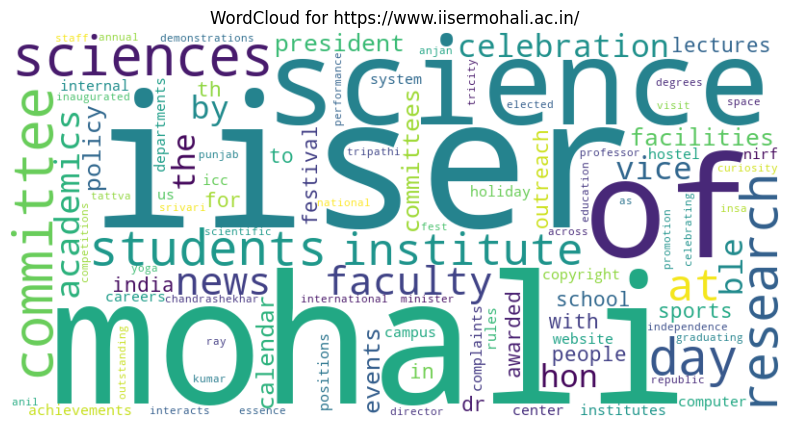

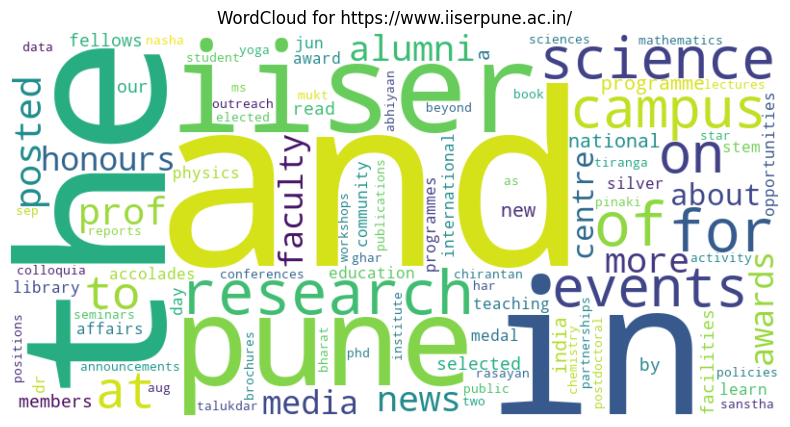

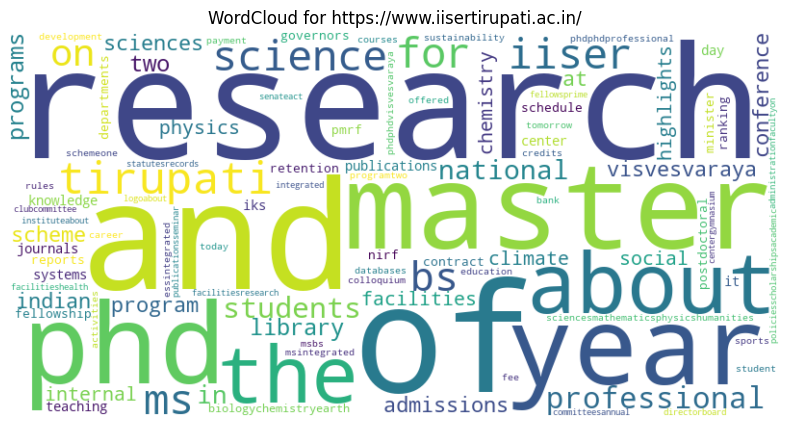

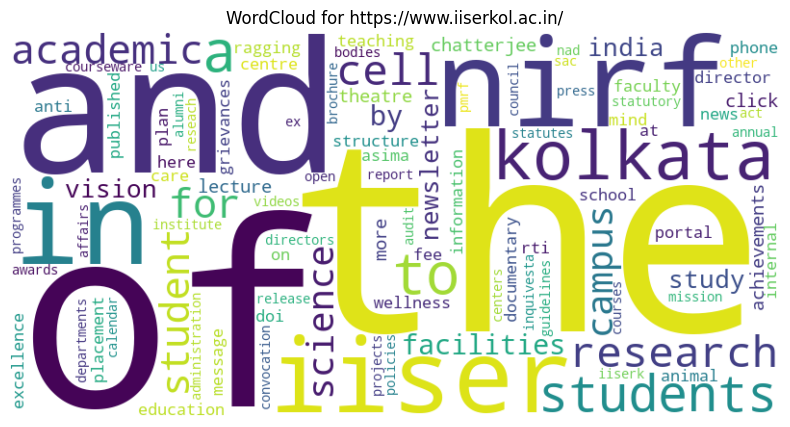

--------------------------------COMPARISON PLOTS-------------------------------------------




=== https://www.iisermohali.ac.in/ vs https://www.iiserpune.ac.in/ ===



-------------------------------------COMMON--------------------------------------------



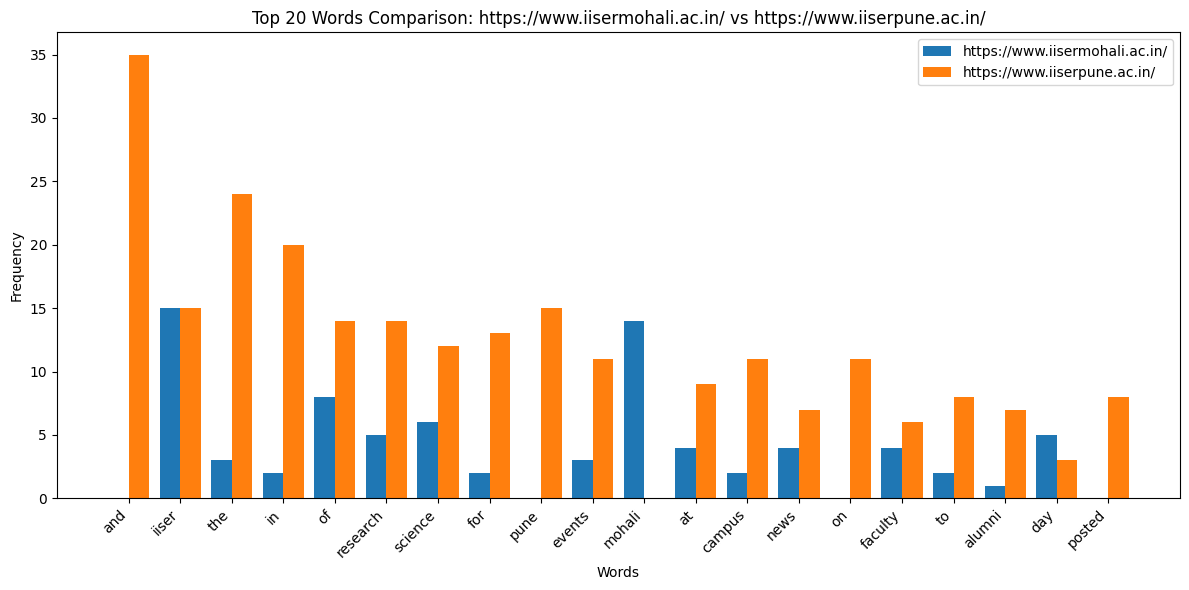


------------------------------------UNCOMMON-------------------------------------------


---------------------------------------------------------------------------------------



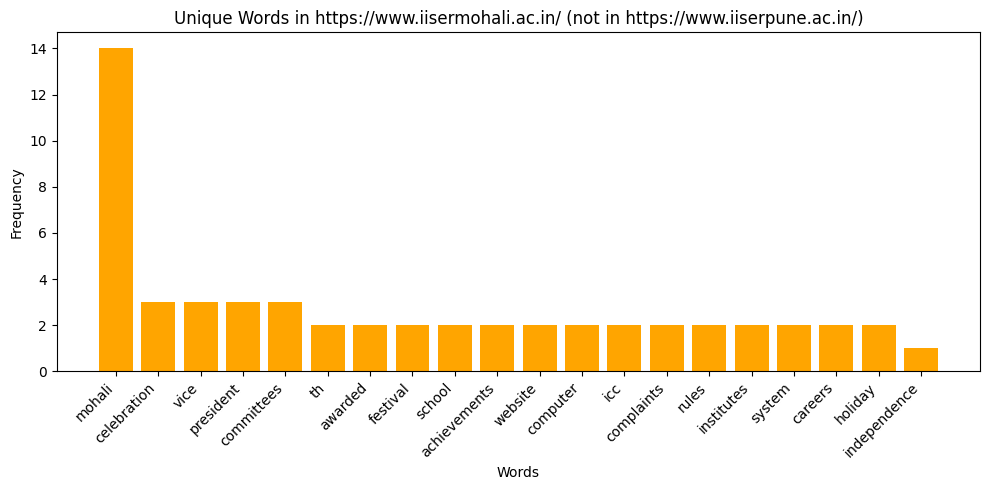


---------------------------------------------------------------------------------------



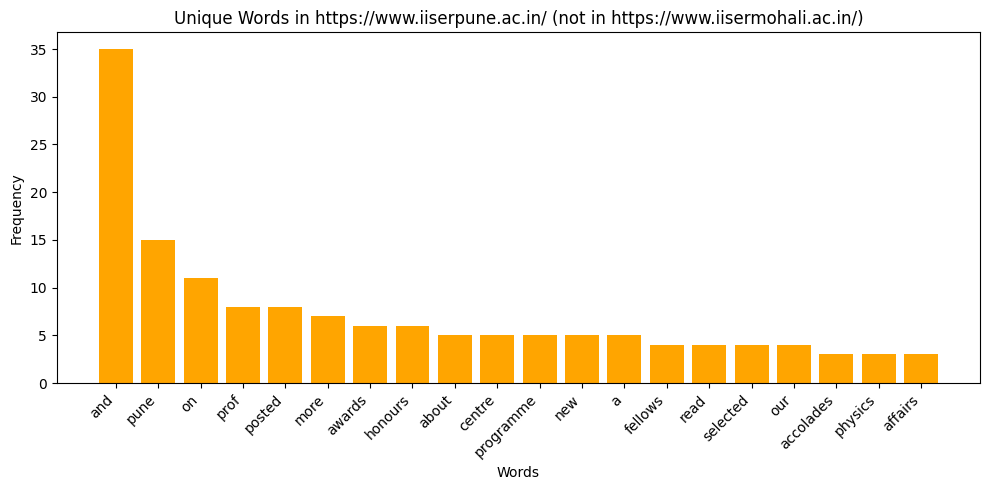




=== https://www.iisermohali.ac.in/ vs https://www.iisertirupati.ac.in/ ===



-------------------------------------COMMON--------------------------------------------



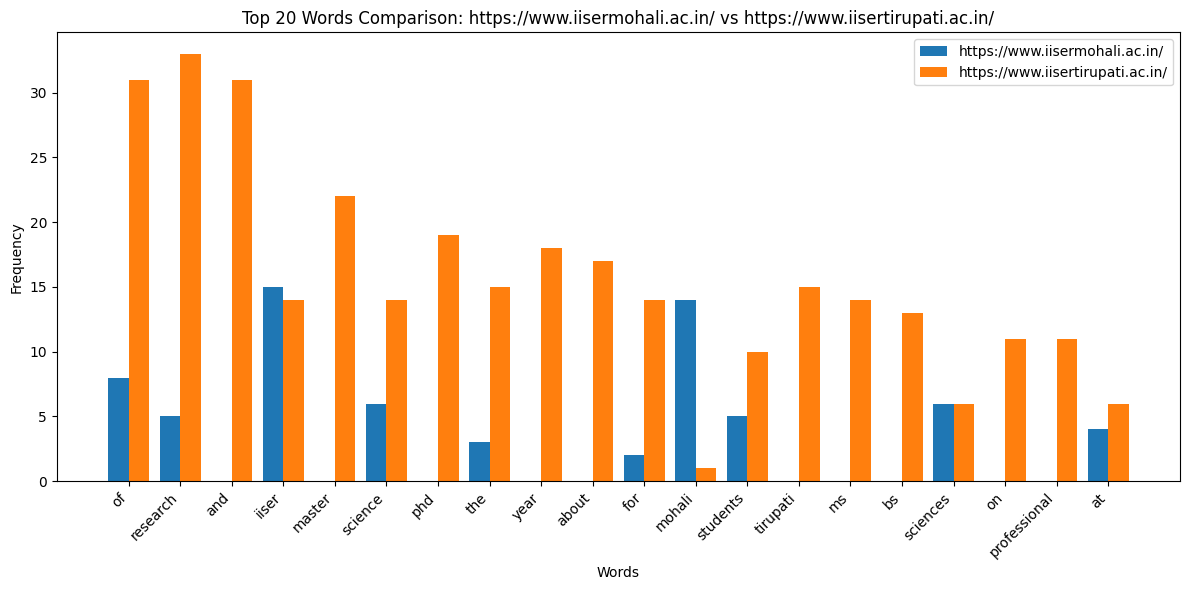


------------------------------------UNCOMMON-------------------------------------------


---------------------------------------------------------------------------------------



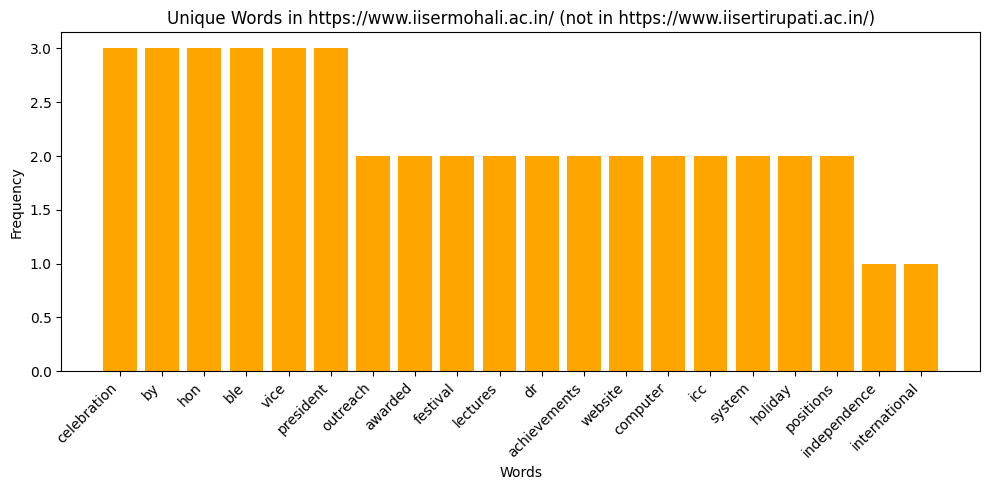


---------------------------------------------------------------------------------------



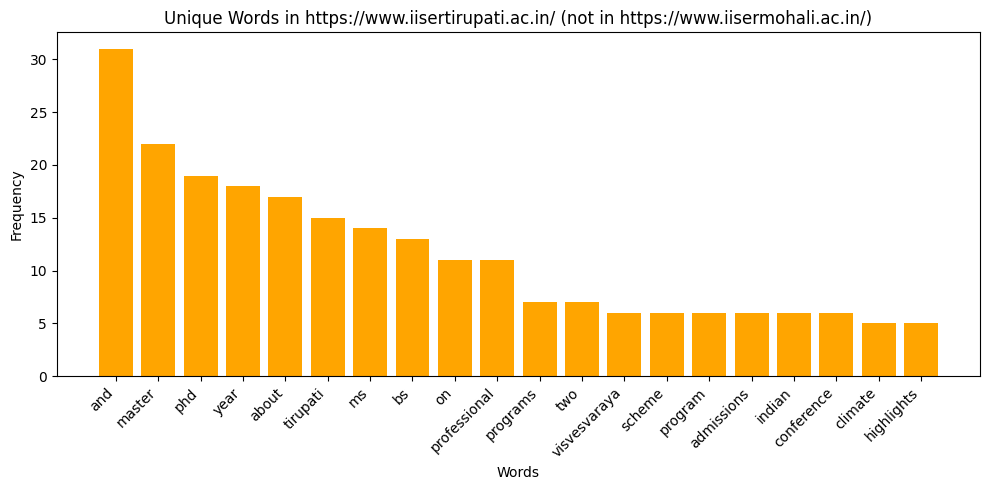




=== https://www.iisermohali.ac.in/ vs https://www.iiserkol.ac.in/ ===



-------------------------------------COMMON--------------------------------------------



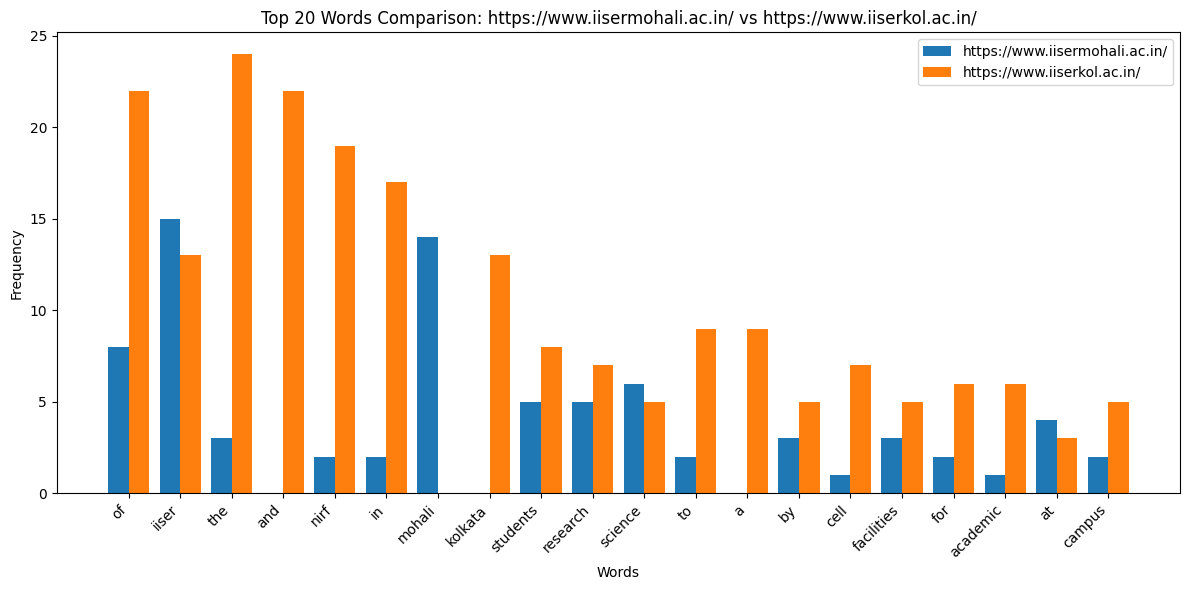


------------------------------------UNCOMMON-------------------------------------------


---------------------------------------------------------------------------------------



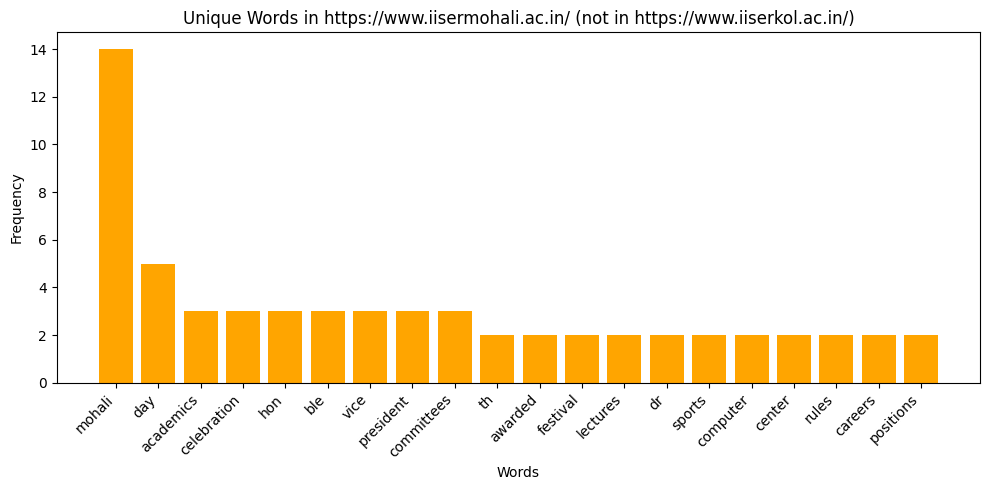


---------------------------------------------------------------------------------------



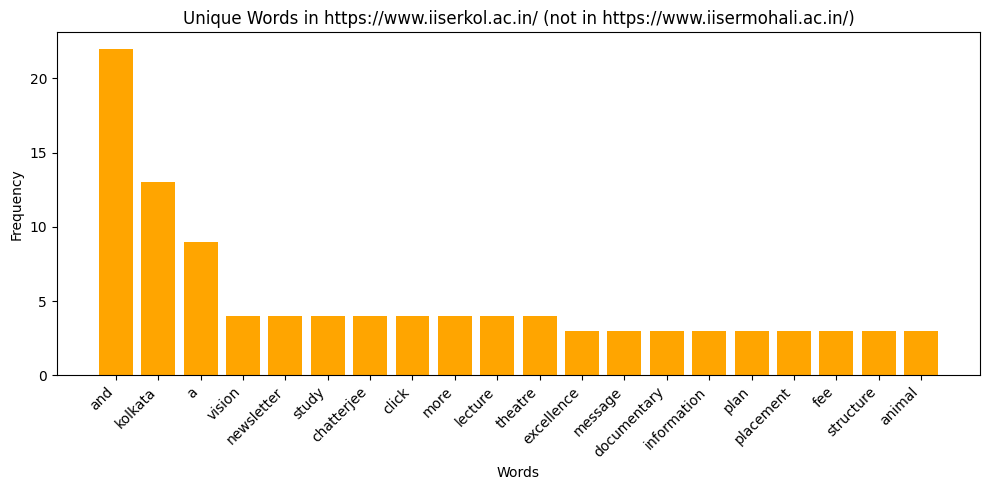




=== https://www.iiserpune.ac.in/ vs https://www.iisertirupati.ac.in/ ===



-------------------------------------COMMON--------------------------------------------



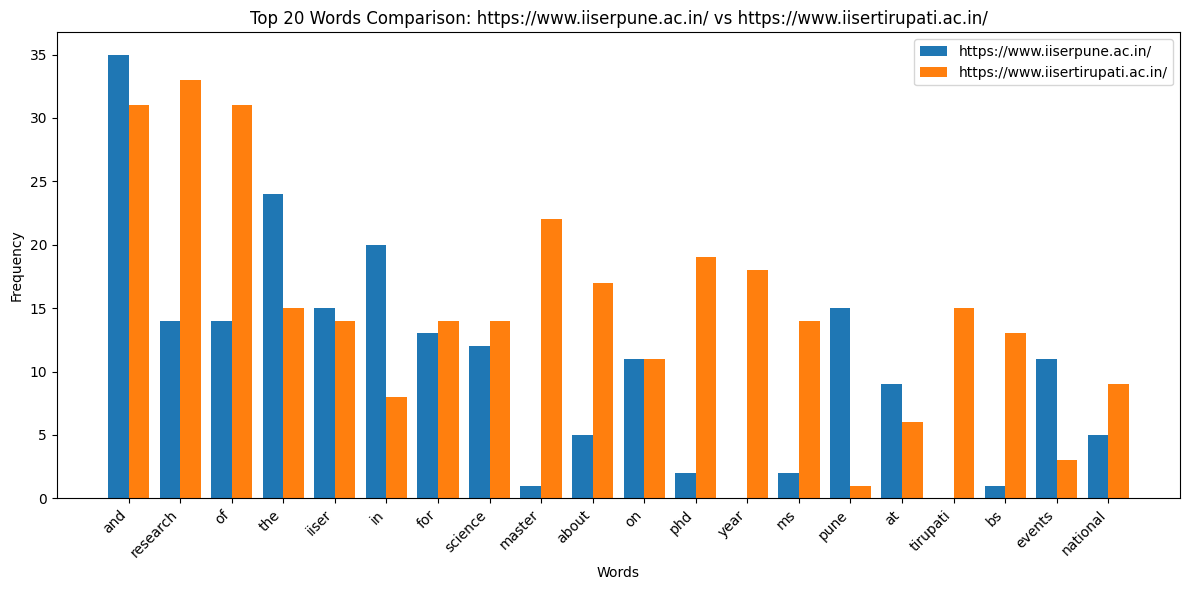


------------------------------------UNCOMMON-------------------------------------------


---------------------------------------------------------------------------------------



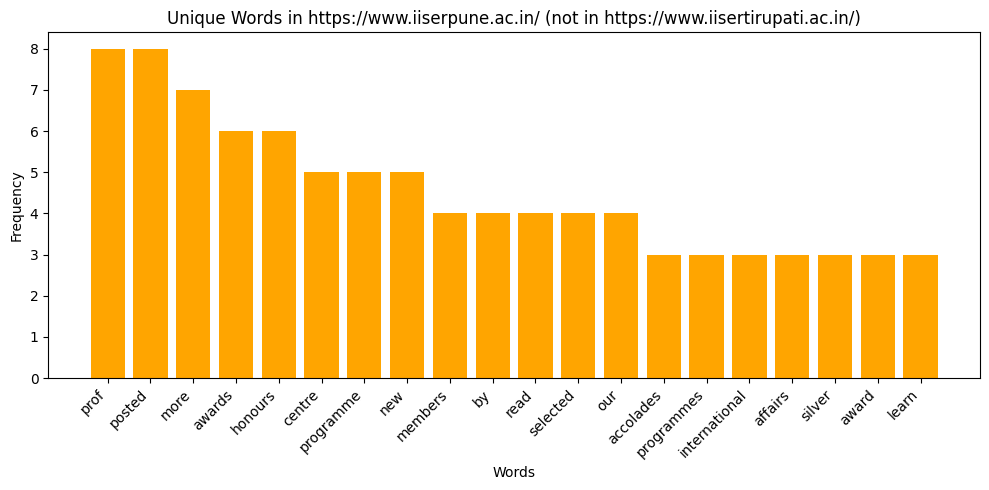


---------------------------------------------------------------------------------------



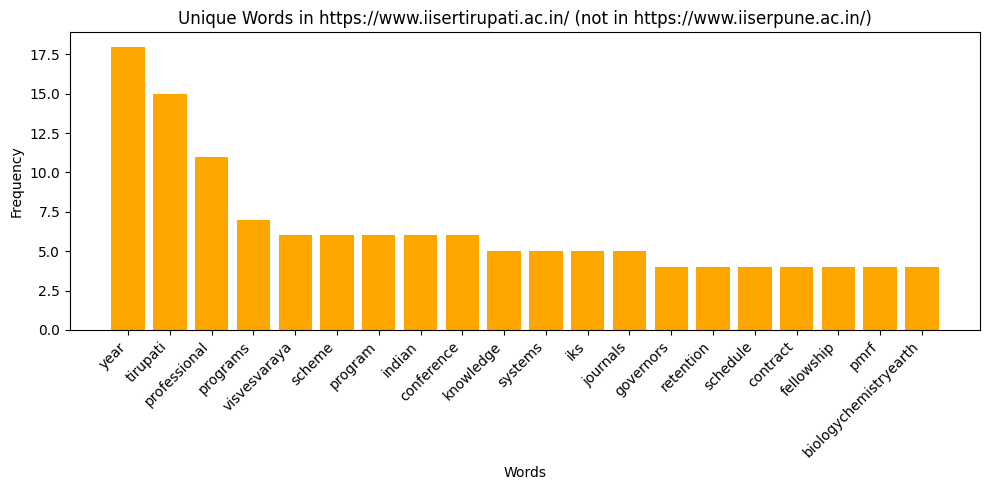




=== https://www.iiserpune.ac.in/ vs https://www.iiserkol.ac.in/ ===



-------------------------------------COMMON--------------------------------------------



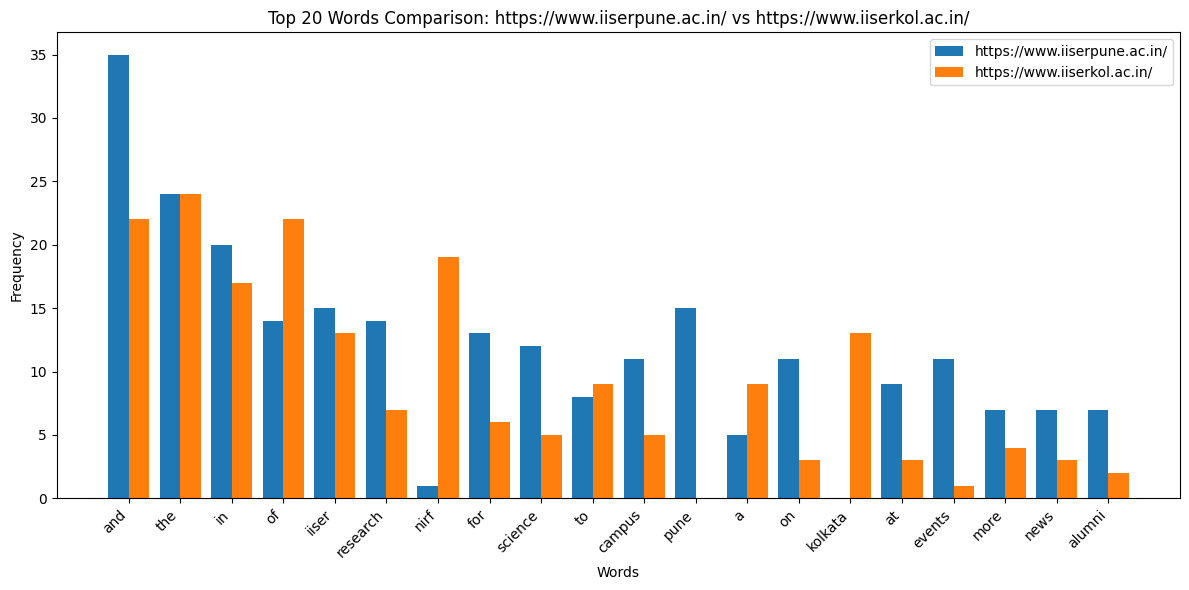


------------------------------------UNCOMMON-------------------------------------------


---------------------------------------------------------------------------------------



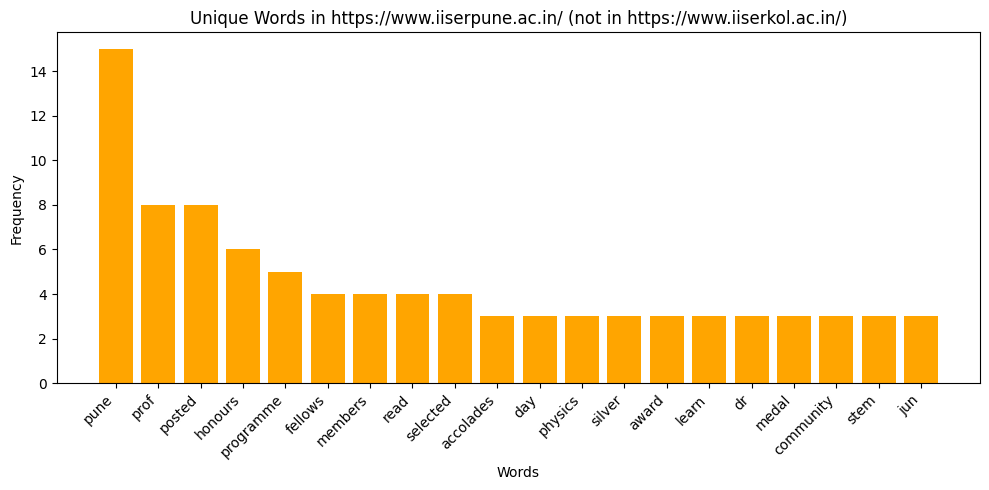


---------------------------------------------------------------------------------------



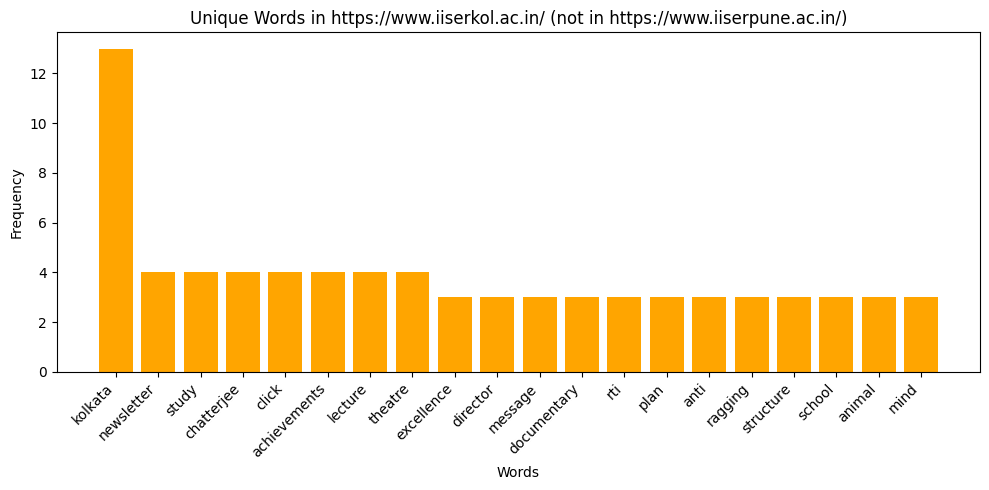




=== https://www.iisertirupati.ac.in/ vs https://www.iiserkol.ac.in/ ===



-------------------------------------COMMON--------------------------------------------



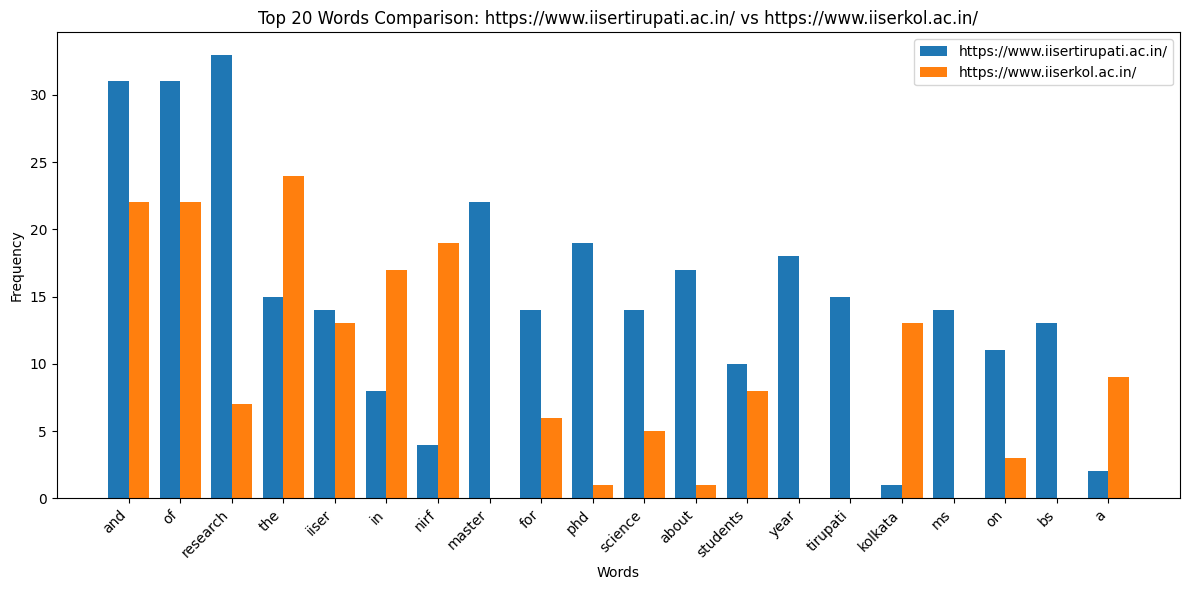


------------------------------------UNCOMMON-------------------------------------------


---------------------------------------------------------------------------------------



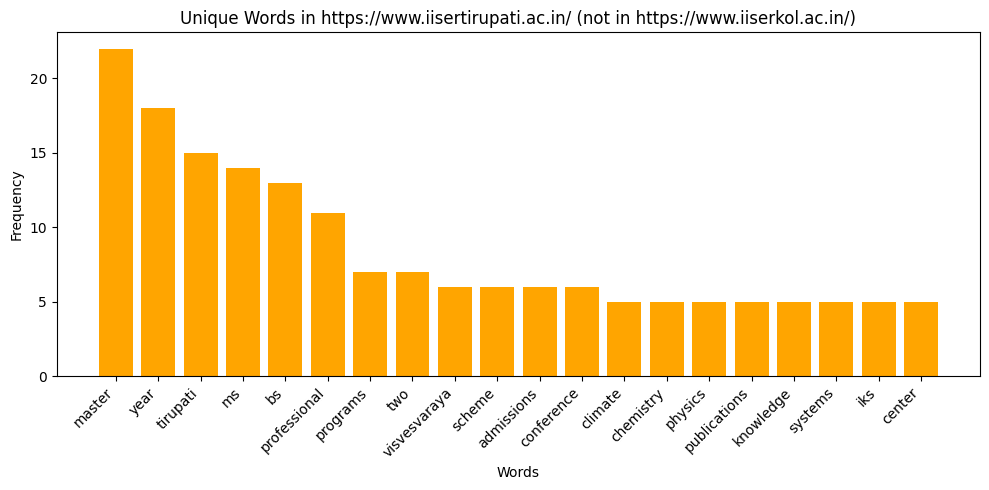


---------------------------------------------------------------------------------------



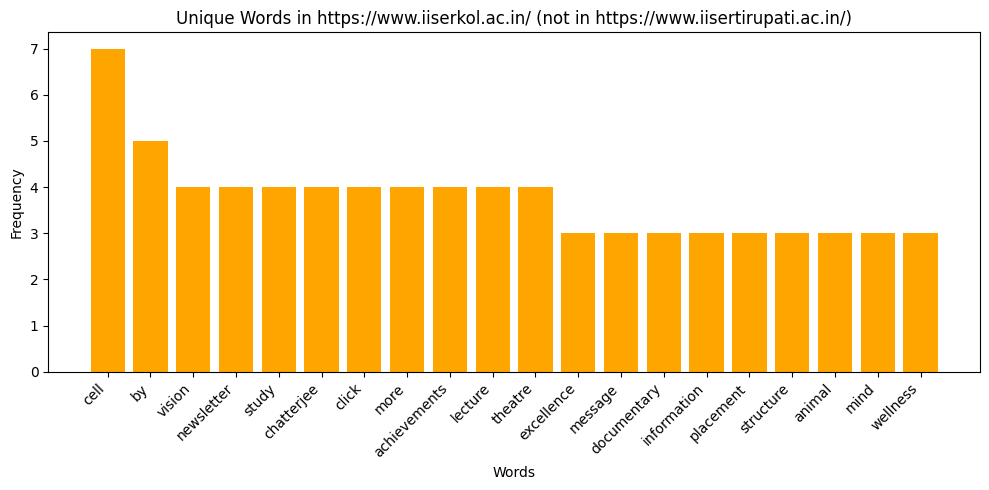

In [133]:
#-------------------------------------------------------------------------------------------------------------------------------#
#-------------------------------------------------------------Plotting----------------------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------#

if __name__ == "__main__":

    urls = [
        "https://www.iisermohali.ac.in/",
        "https://www.iiserpune.ac.in/",
        "https://www.iisertirupati.ac.in/",
        "https://www.iiserkol.ac.in/"
    ]

    conn = initiate_db("keywords.db")   
    try:
        for u in urls:
            wc: Counter = scrape_clean_count(u)   # our existing function.
            save_counter_overwrite(conn, u, wc)   # after scraping to add in data base.
    finally:
        print ("-------------------------------------WORD CLOUD--------------------------------------------")
        print ("")
        for i in range(len(urls)):
            print ("")
            wordcloud(conn,urls[i])

        print ("--------------------------------COMPARISON PLOTS-------------------------------------------")
        print ("")
        for i in range(len(urls)):
            for j in range(i + 1, len(urls)):
                u1, u2 = urls[i], urls[j]
                print ("")
                print(f"\n\n=== {u1} vs {u2} ===\n")
                print ("")
                freq_plots(conn, u1, u2)

    conn.close()


    


## YAKE IMPLEMENTATION FOR BETTER WORD SELECTION AFTER SCRAPING.



=== YAKE extraction for https://www.iisermohali.ac.in/ ===

Successfully fetched the webpage!: https://www.iisermohali.ac.in/



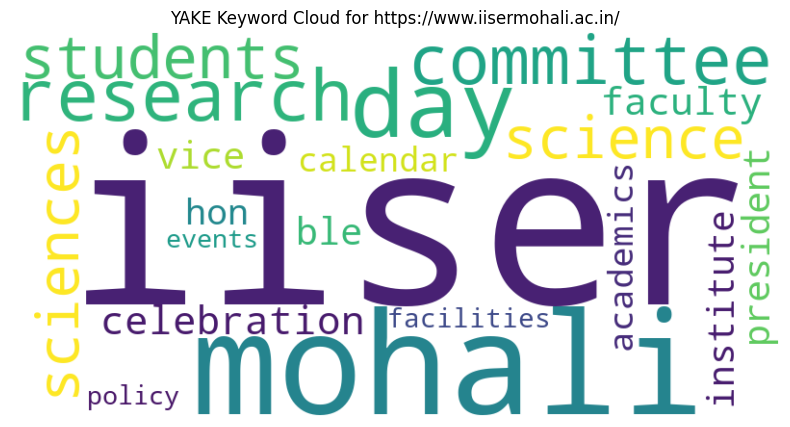


Top YAKE Keywords for https://www.iisermohali.ac.in/:

Keyword                   Score
---------------------------------------------
iiser                  0.004085
mohali                 0.004981
day                    0.016648
research               0.016648
committee              0.017783
students               0.018807
science                0.019928
sciences               0.019928
celebration            0.020317
faculty                0.021518
ble                    0.022610
president              0.022610
vice                   0.022610
institute              0.023509
hon                    0.024999
academics              0.026343
calendar               0.027477
facilities             0.027477
events                 0.030039
policy                 0.030039


=== YAKE extraction for https://www.iiserpune.ac.in/ ===

Successfully fetched the webpage!: https://www.iiserpune.ac.in/



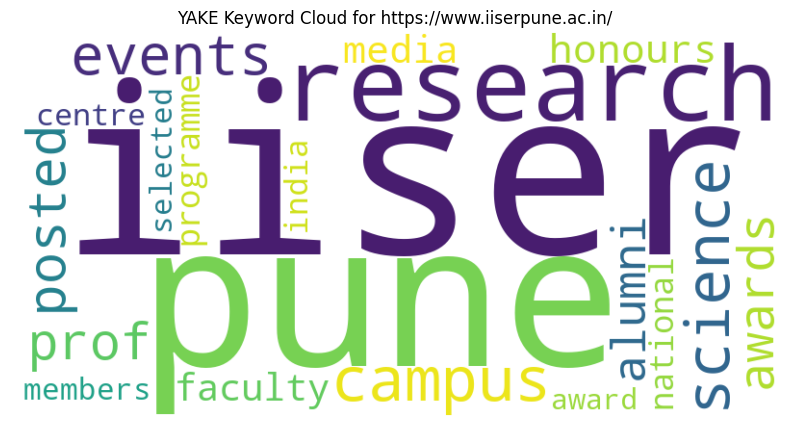


Top YAKE Keywords for https://www.iiserpune.ac.in/:

Keyword                   Score
---------------------------------------------
iiser                  0.002162
pune                   0.002455
research               0.003484
campus                 0.004702
science                0.004821
events                 0.005628
posted                 0.006233
prof                   0.006781
awards                 0.007386
alumni                 0.008051
honours                0.008199
media                  0.008593
faculty                0.008994
programme              0.011757
national               0.011877
india                  0.012414
centre                 0.012809
members                0.013674
selected               0.013674
award                  0.014773


=== YAKE extraction for https://www.iisertirupati.ac.in/ ===

Successfully fetched the webpage!: https://www.iisertirupati.ac.in/



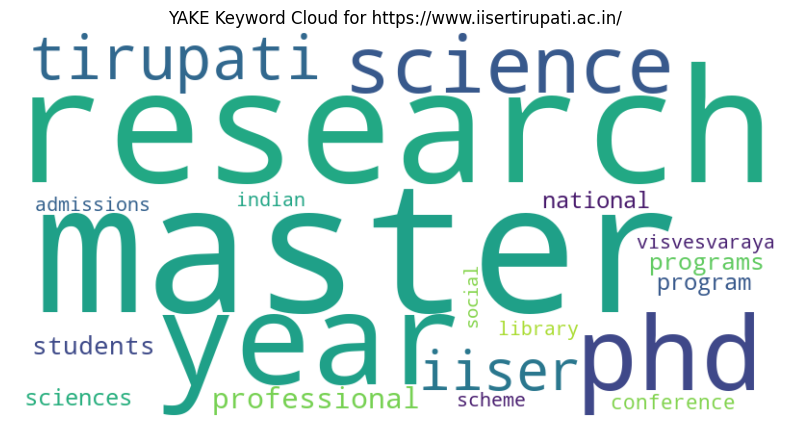


Top YAKE Keywords for https://www.iisertirupati.ac.in/:

Keyword                   Score
---------------------------------------------
master                 0.001296
research               0.001331
year                   0.001992
phd                    0.002080
science                0.002719
tirupati               0.003666
iiser                  0.003910
professional           0.003911
students               0.005532
programs               0.005813
sciences               0.006344
national               0.006501
program                0.006782
conference             0.008970
indian                 0.009447
visvesvaraya           0.009447
scheme                 0.009934
library                0.009968
admissions             0.010158
social                 0.011065


=== YAKE extraction for https://www.iiserkol.ac.in/ ===

Successfully fetched the webpage!: https://www.iiserkol.ac.in/



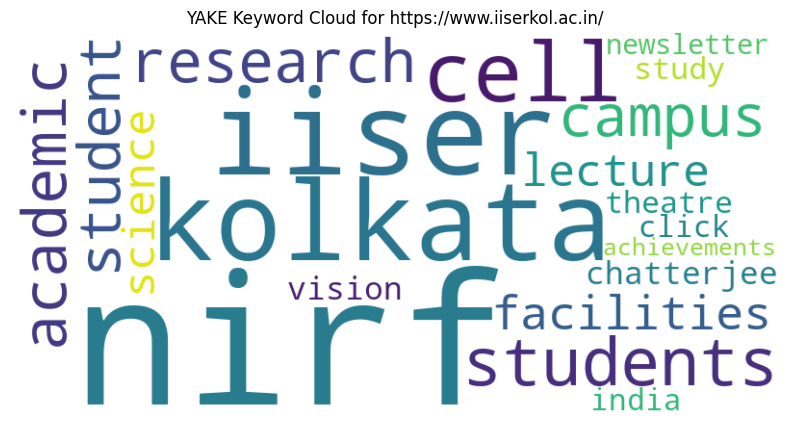


Top YAKE Keywords for https://www.iiserkol.ac.in/:

Keyword                   Score
---------------------------------------------
nirf                   0.001016
iiser                  0.003401
kolkata                0.003809
cell                   0.007689
students               0.007994
academic               0.009590
research               0.009820
campus                 0.010620
student                0.010659
facilities             0.012044
lecture                0.013063
science                0.013613
chatterjee             0.013993
vision                 0.013993
theatre                0.014949
study                  0.014949
click                  0.015931
india                  0.015931
newsletter             0.015931
achievements           0.017969


In [135]:
#-------------------------------------------------------------------------------------------------------------------------------#
#---------------------------------------------------------YAKE INTEGRATION------------------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------#

def yake_keywords_extract(text: str, max_keywords: int = 20):
    kw_extractor = yake.KeywordExtractor(lan="en", n=1, top=max_keywords)
    return kw_extractor.extract_keywords(text)


def get_yake_for_url(conn: sqlite3.Connection, url: str, limit: int = 20):
    sql = "SELECT keyword, score FROM yake_keywords WHERE url = ? ORDER BY score ASC LIMIT ?"
    cur = conn.execute(sql, (url, limit))
    return cur.fetchall()


def yake_wordcloud(conn, url: str):
    yake_data = get_yake_for_url(conn, url, limit=20)
    if not yake_data:
        print(f"No YAKE data found for {url}")
        return
    freq_dict = {kw: 1/score for kw, score in yake_data}  # inverse score = higher importance
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"YAKE Keyword Cloud for {url}")
    plt.show()
    print(f"\nTop YAKE Keywords for {url}:\n")
    print(f"{'Keyword':<20} {'Score':>10}")
    print("-"*45)
    for kw, score in yake_data:
        print(f"{kw:<20} {score:>10.6f}")



#-------------------------------------------------------------------------------------------------------------------------------#
#----------------------------------------------------RUN YAKE AFTER SCRAPING----------------------------------------------------#  
#-------------------------------------------------------------------------------------------------------------------------------#
 
if __name__ == "__main__":

    urls = [
        "https://www.iisermohali.ac.in/",
        "https://www.iiserpune.ac.in/",
        "https://www.iisertirupati.ac.in/",
        "https://www.iiserkol.ac.in/"
    ]
    conn = initiate_db("YAKE.db")  

    for u in urls:
        print(f"\n\n=== YAKE extraction for {u} ===\n")
        # Use the clean text you already have for this URL.
        yake_results = yake_keywords_extract(clean_text(u),max_keywords=20)
        save_yake_keywords(conn, u, yake_results)
        yake_wordcloud(conn, u)

    conn.close()

  